In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import scanpy as sc
import anndata as ad
import muon as mu
from muon import MuData 
import mofax as mfx

/usr/local/python/3.12.1/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
# Transposing (genes -> columns, samples -> rows)

rna_df = pd.read_csv('transcriptomics_data.csv', index_col=0).T
proteome_df = pd.read_csv('proteomics_data.csv', index_col=0).T
meth_df = pd.read_csv('methylation_data.csv', index_col=0).T
metabolomis_df = pd.read_csv('metabolomics_data.csv', index_col=0).T
clinical_data_df = pd.read_csv('labels.csv', index_col=0)

In [9]:
#AnnData objects
rna_adata = sc.AnnData(X=rna_df)
proteome_adata = sc.AnnData(X=proteome_df)
meth_adata = sc.AnnData(X=meth_df)
metabo_adata = sc.AnnData(X=metabolomis_df)

In [10]:
# MuData Object
mdata = MuData({"RNA": rna_adata, "Proteome": proteome_adata, "Methylation": meth_adata, "Metabolomics": metabo_adata})
mdata

/usr/local/python/3.12.1/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/usr/local/python/3.12.1/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("obs", axis=1, join_common=join_common)


MuData object with n_obs × n_vars = 200 × 6660
  4 modalities
    RNA:	200 x 3234
    Proteome:	200 x 2187
    Methylation:	200 x 1110
    Metabolomics:	200 x 129

In [13]:
for i in ['RNA', 'Proteome', 'Methylation', 'Metabolomics']:
    mdata.mod[i].X = mdata.mod[i].X.astype(np.float64)

In [14]:
#
#   RUNNING MOFA INTEGRATION
#

mu.tl.mofa(
    mdata,
    use_obs='union',
    n_factors=15,
    convergence_mode='medium',
    outfile="model.hdf5"
)


        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        
Loaded view='RNA' group='group1' with N=200 samples and D=3234 features...
Loaded view='Proteome' group='group1' with N=200 samples and D=2187 features...
Loaded view='Methylation' group='group1' with N=200 samples and D=1110 features...
Loaded view='Metabolomics' group='group1' with N=200 samples and D=129 features...


Model options:
- Automatic Relevance Determination prior o

In [15]:
m = mfx.mofa_model("model.hdf5")
m

MOFA+ model: model
Samples (cells): 200
Features: 6660
Groups: group1 (200)
Views: Metabolomics (129), Methylation (1110), Proteome (2187), RNA (3234)
Factors: 15
Expectations: W, Z

In [18]:
def process_mofa_weights(model):
    weights = model.get_weights()
    weights_df = pd.DataFrame(weights)
    return weights_df

def get_top_features(weights_df, n_features=70):
    top_features = {}
    for factor in range(weights_df.shape[1]):
        # absolute weights
        abs_weights = np.abs(weights_df.iloc[:, factor])
        # top features
        top_indices = abs_weights.nlargest(n_features).index
        top_features[f"Factor_{factor+1}"] = top_indices.tolist()
    return top_features

weights_df = process_mofa_weights(m)

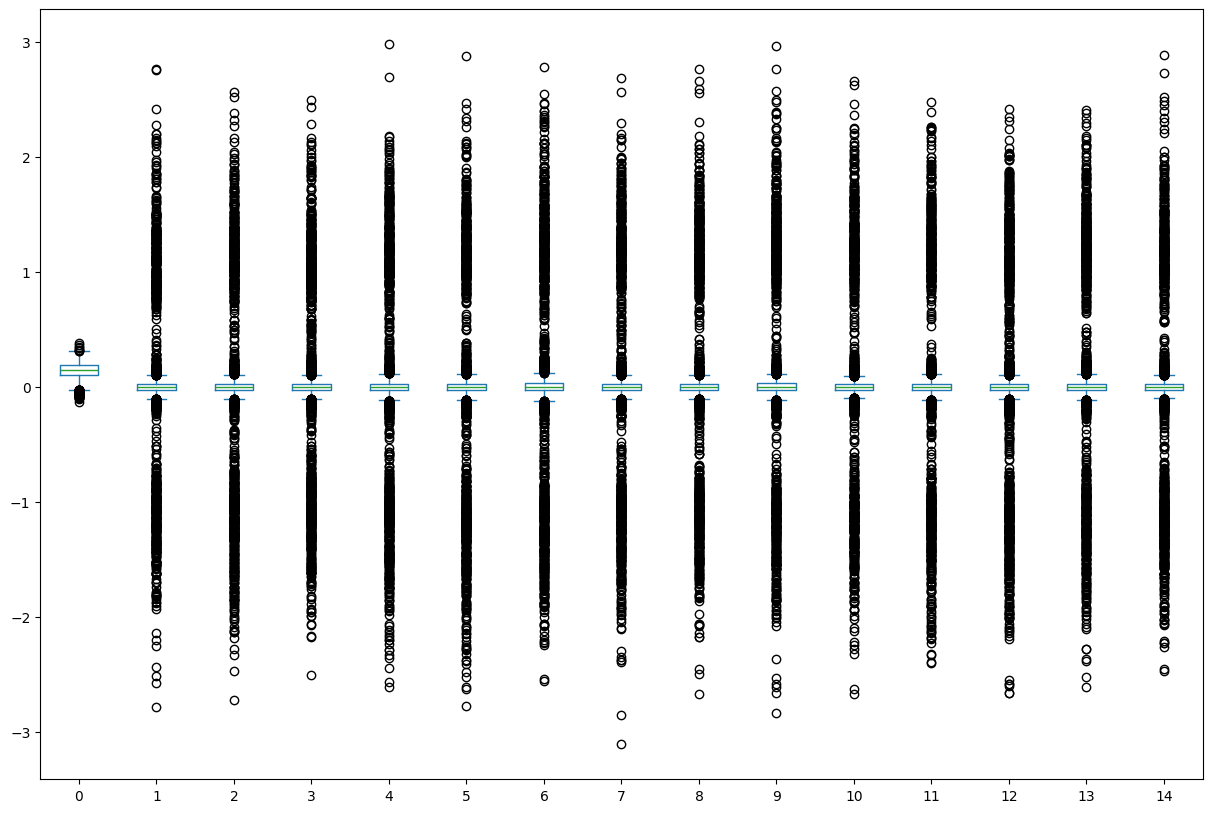

In [19]:
ax =  weights_df.plot(kind='box', figsize=(15, 10))


<Axes: xlabel='Feature rank', ylabel='Factor1 weight'>

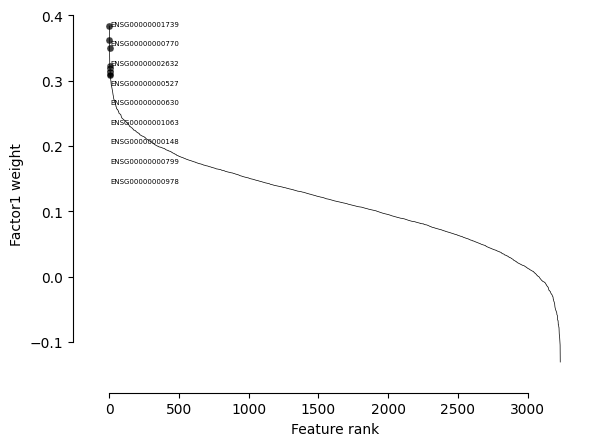

In [20]:
mfx.plot_weights_ranked(m)

<Axes: >

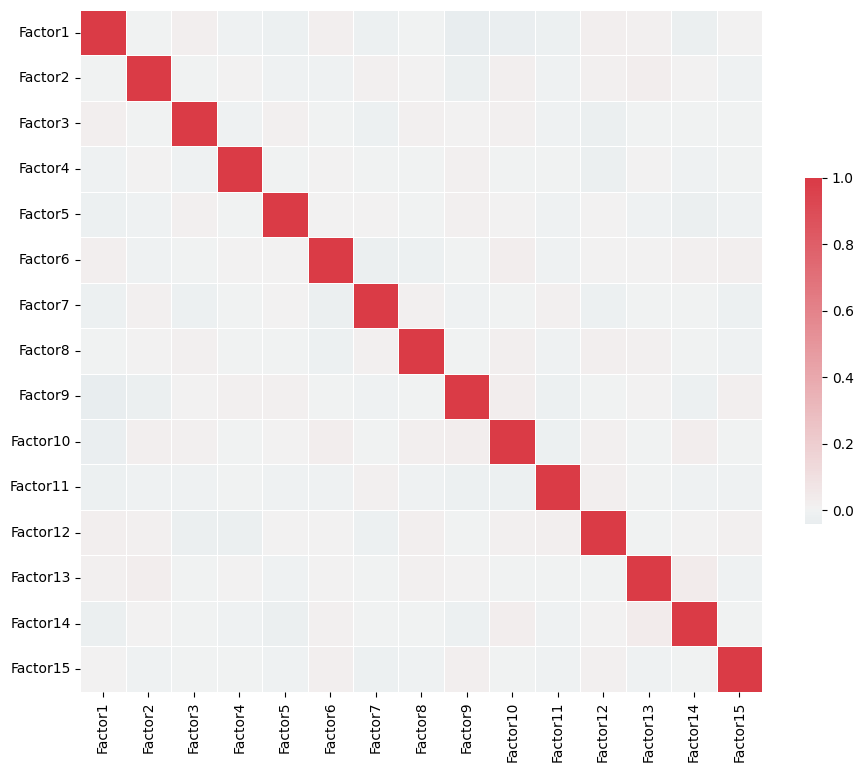

In [21]:
mfx.plot_weights_correlation(m)

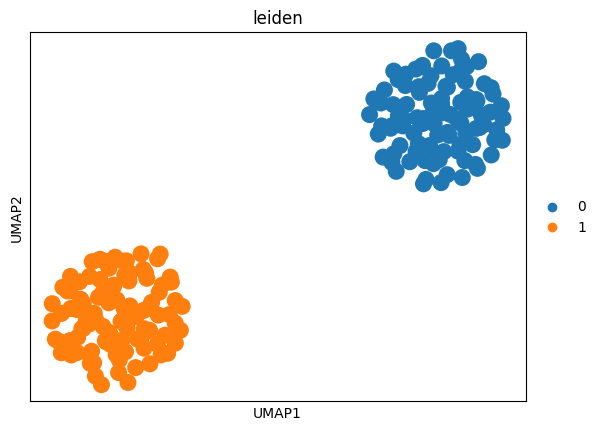

In [22]:
sc.pp.neighbors(mdata, use_rep="X_mofa")
sc.tl.umap(mdata)
sc.tl.leiden(mdata)


sc.pl.umap(mdata, color="leiden", save="mofa2_umap_leiden.png")